![](https://miro.medium.com/max/1225/1*HMz19VKei5ZsvNAVmv_OMQ.png)

Generally, an affine transformation has 6 degrees of freedom, warping any image to another location after matrix multiplication pixel by pixel. **The transformed image preserved both parallel and straight line in the original image** (think of shearing)

Interested transforms:
- Rotation
- Translation
- Scaling
![](https://i.imgur.com/awQd8fP.png)

As the above operations are linear, which means they satisfy the following condition:
![](https://i.imgur.com/1EEhuzR.png)

We could represent a rotation followed by a translation as
```
A = array([[cos(angle),  -sin(angle), tx],
            [sin(angle), cos(angle),  ty],
            [0,          0,           1]])
```

In Python and OpenCV, the coordinate system of a 2D matrix is as following:
![](https://i.imgur.com/htpd9vs.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def prepare_canvas(xlim=(-5, 5), ylim=(-5, 5)):
    plt.figure(figsize=(16, 16))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(np.arange(xlim[0], xlim[1]+1))
    plt.yticks(np.arange(ylim[0], ylim[1]+1))
    plt.grid(True)

# Get coordinates for grid
def get_grid(x, y, offset=0, homogeneous=False):
    coords = np.indices((x, y)).reshape(2, -1)
    coords[0, :] -= offset
    coords[1, :] -= offset
    coords = coords if not homogeneous else np.vstack((coords, np.ones(coords.shape[1])))
    return coords

# Define Affine transformation
def get_rotation(degree):
    theta = np.radians(degree)
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return R

def get_translation(tx, ty):
    T = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])
    return T

def get_scale(s):
    S = np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])
    return S

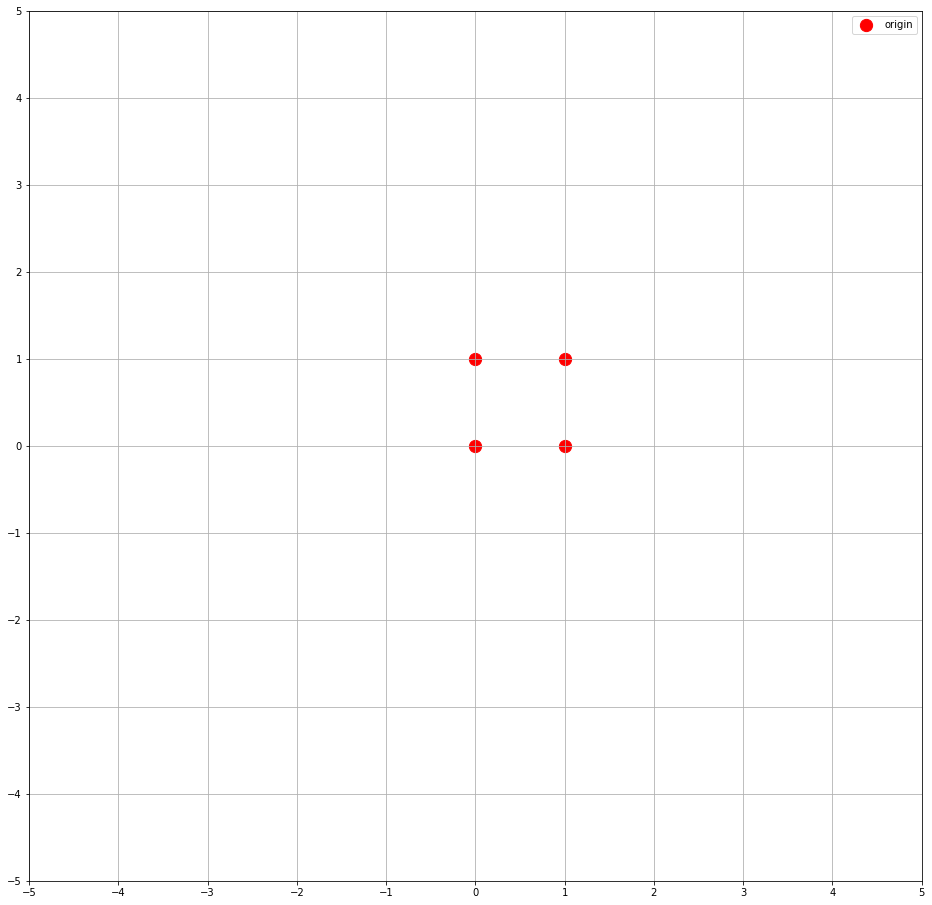

In [29]:
prepare_canvas()

# Points in homogeneous coodinates
points = np.array([[0, 1, 0, 1], # x
                   [0, 0, 1, 1], # y
                   [1, 1, 1, 1]])

# Plot affine transformed result
plt.scatter(points[0, :],
            points[1, :],
            s=150, c='red', label='origin')

plt.legend()

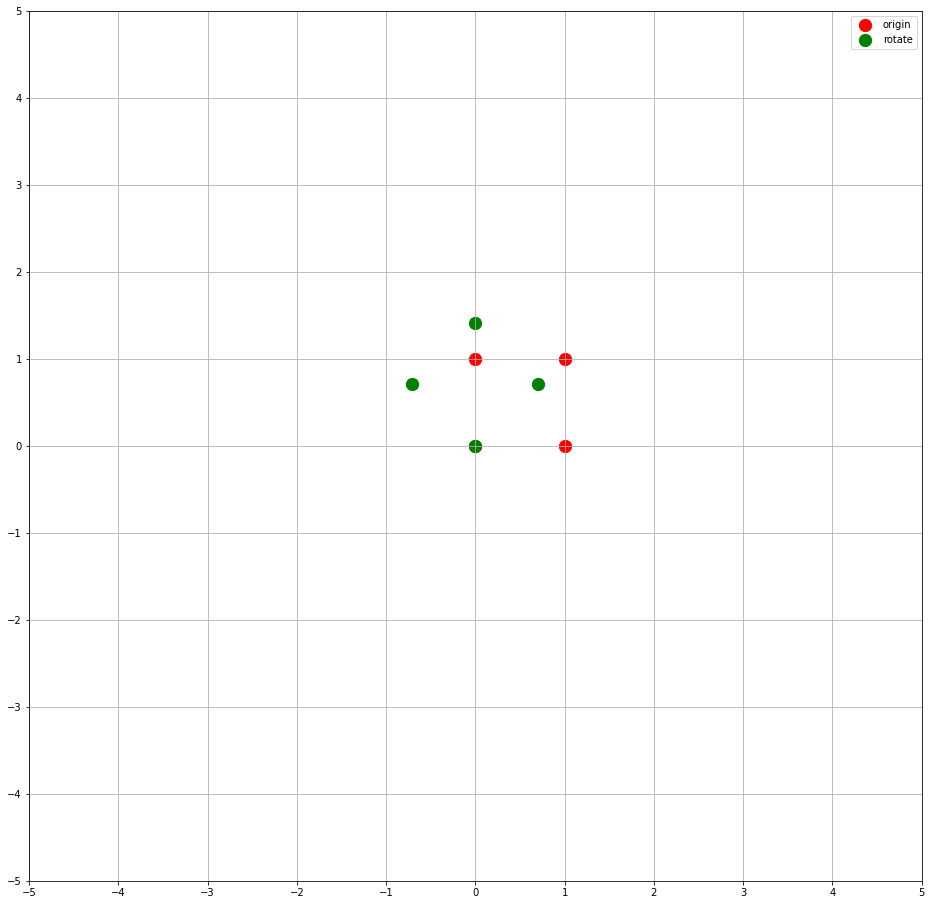

In [30]:
prepare_canvas()

# Points in homogeneous coodinates
points = np.array([[0, 1, 0, 1], # x
                   [0, 0, 1, 1], # y
                   [1, 1, 1, 1]])
R = get_rotation(45)
points_rot = R @ points

# Plot affine transformed result
plt.scatter(points[0, :],
            points[1, :],
            s=150, c='red', label='origin')
plt.scatter(points_rot[0, :],
            points_rot[1, :],
            s=150, c='green', label='rotate')

plt.legend()

In [31]:
print(R)

[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


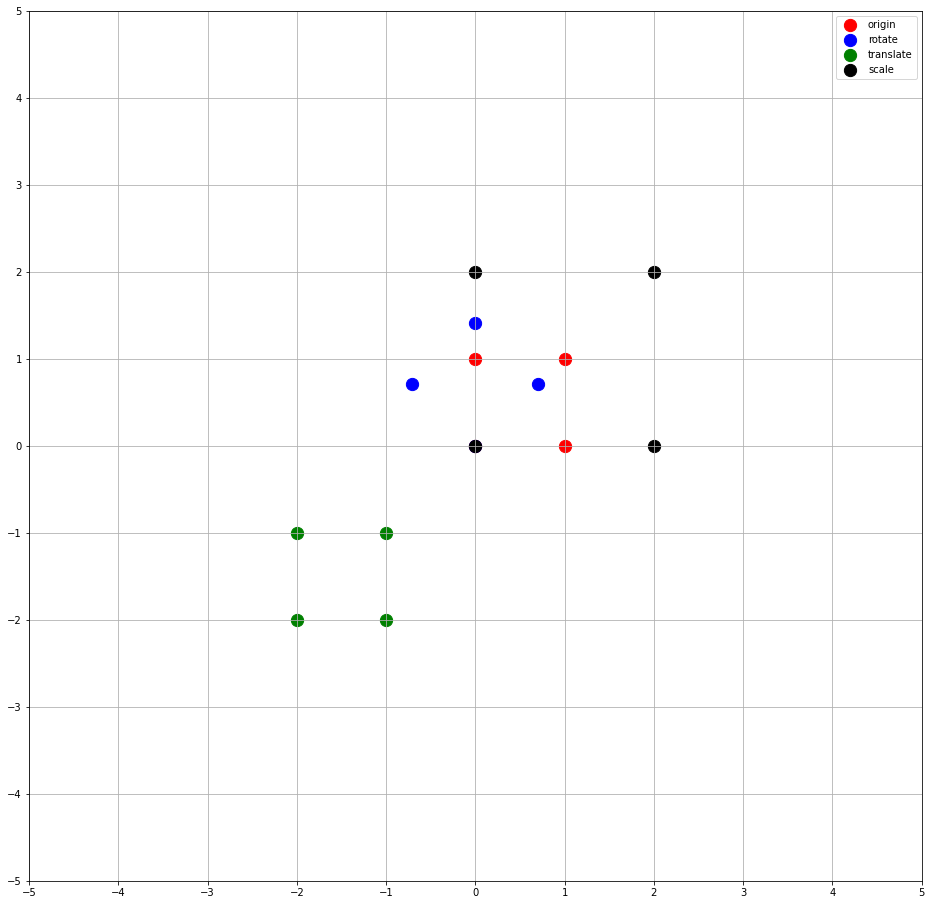

In [3]:
prepare_canvas()

# Points in homogeneous coodinates
points = np.array([[0, 1, 0, 1], # x
                   [0, 0, 1, 1], # y
                   [1, 1, 1, 1]])

# Simple affine transformation of each type
R = get_rotation(45)
T = get_translation(-2, -2)
S = get_scale(2)

# Apply affine transformation
points_rot = R @ points
points_trans = T @ points
points_scale = S @ points

# Plot affine transformed result
plt.scatter(points[0, :], points[1, :], s=150, c='red', label='origin')
plt.scatter(points_rot[0, :], points_rot[1, :], s=150, c='blue', label='rotate')
plt.scatter(points_trans[0, :], points_trans[1, :], s=150, c='green', label='translate')
plt.scatter(points_scale[0, :], points_scale[1, :], s=150, c='black', label='scale')

plt.legend()

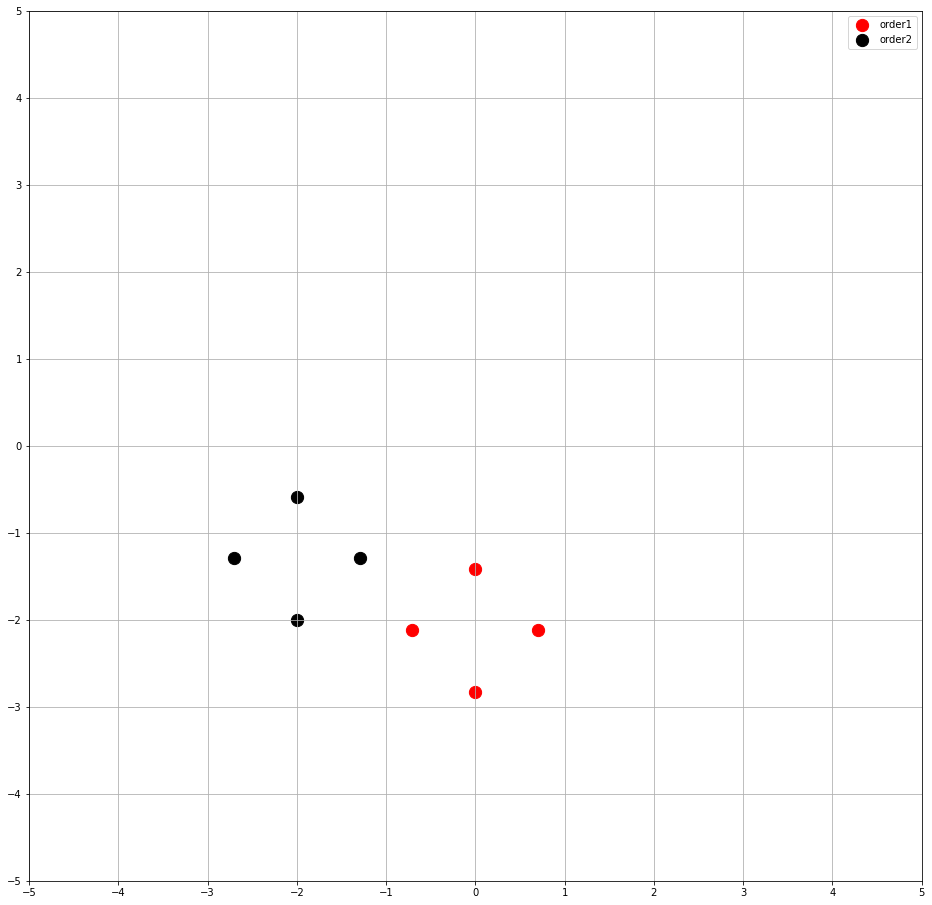

In [4]:
prepare_canvas()

# Points in homogeneous coodinates
points = np.array([[0, 1, 0, 1], # x
                   [0, 0, 1, 1], # y
                   [1, 1, 1, 1]])

# Simple affine transformation of each type
R = get_rotation(45)
T = get_translation(-2, -2)

# Apply same affine transformation matrix with different order
pts1 = R @ (T @ points)
pts2 = T @ (R @ points)

plt.scatter(pts1[0, :],
            pts1[1, :],
            s=150, c='red', label='order1')
plt.scatter(pts2[0, :],
            pts2[1, :],
            s=150, c='black', label='order2')

plt.legend()

The steps needs to be taken for image transformation
- Create a new image I(x, y) to ouptupt the transform points
- Apply the transformation A
- Project the points onto a new image plane, only considering those that lie within image boundary

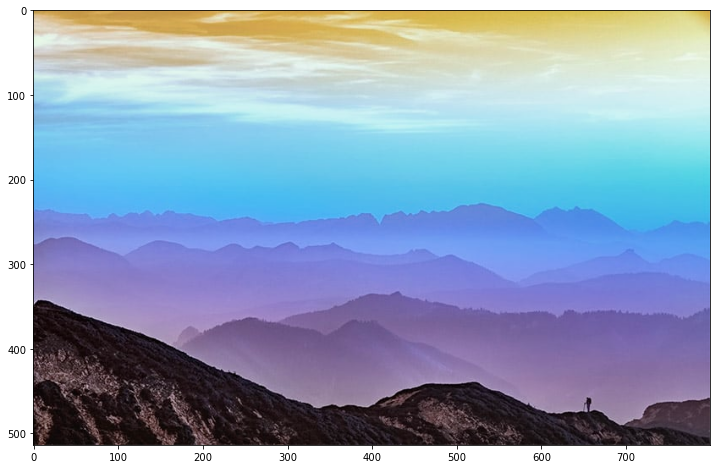

In [34]:
import cv2

img = cv2.imread('./landscape.jpg')
height, width = img.shape[:2]

tx, ty = np.array((width//2, height//2))
degree = 45
scale = 2.0

T = get_translation(tx, ty)
R = get_rotation(degree)
S = get_scale(scale)


A = T @ R @ S @ np.linalg.inv(T)

plt.figure(figsize=(16, 8))
plt.imshow(img);

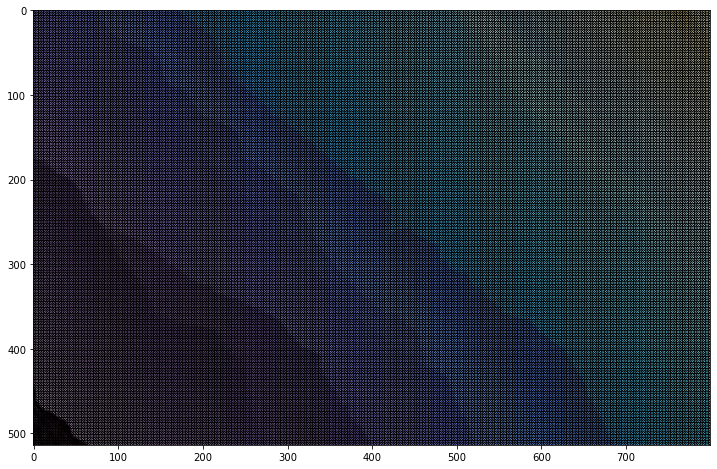

In [27]:
coords = get_grid(width, height, homogeneous=True)
Xs = coords[0].astype(np.int)
Ys = coords[1].astype(np.int)

# Step2: Apply Transformation
warp_coords = np.round(A @ coords).astype(np.int)
Xs_warp = warp_coords[0]
Ys_warp = warp_coords[1]
indices = np.where((Xs_warp >= 0) & (Xs_warp < width) &
                   (Ys_warp >= 0) & (Ys_warp < height))

valid_Xs = Xs[indices]
valid_Ys = Ys[indices]
valid_Xs_warp = Xs_warp[indices]
valid_Ys_warp = Ys_warp[indices]

# Map the pixel RGB data to new locaiton in another array
canvas = np.zeros_like(img)
canvas[valid_Ys_warp, valid_Xs_warp] = img[valid_Ys, valid_Xs]

plt.figure(figsize=(16, 8))
plt.imshow(canvas)

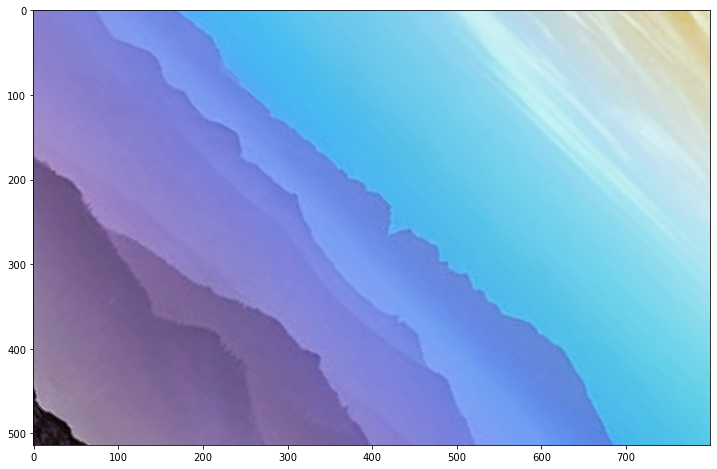

In [26]:
coords = get_grid(width, height, homogeneous=True)
Xs = coords[0].astype(np.int)
Ys = coords[1].astype(np.int)

warp_coords = (np.linalg.inv(A) @ coords).astype(np.int)
Xs_warp = warp_coords[0]
Ys_warp = warp_coords[1]

indices = np.where((Xs_warp >= 0) & (Xs_warp < width) &
                   (Ys_warp >= 0) & (Ys_warp < height))

valid_Xs = Xs[indices]
valid_Ys = Ys[indices]
valid_Xs_warp = Xs_warp[indices]
valid_Ys_warp = Ys_warp[indices]

# Map the pixel RGB data to new locaiton in another array
canvas = np.zeros_like(img)
canvas[valid_Ys, valid_Xs] = img[valid_Ys_warp, valid_Xs_warp]

plt.figure(figsize=(16, 8))
plt.imshow(canvas)